**Pré processamento**

Passo a passo:

1) Filtragem de ruído
2) Binarização adaptativa
3) Segmentação de caracteres


In [329]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [330]:
def display_image(img, title):
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(title)


def read_captcha_image(path):
    img = cv2.imread(path)
    display_image(img, 'Original Captcha Image')
    return img


def median_filter(img):
    filtered_image = cv2.medianBlur(img, 3)
    display_image(filtered_image, 'filtered_image')
    return filtered_image


def mean_filter(img):
    filtered_image = cv2.filter2D(img, -1, np.ones((3, 3), dtype=np.float32) / (3**2))
    display_image(filtered_image, 'filtered_image')
    return filtered_image

def plot_hist(image):
    pixel_values = image.flatten()
    plt.figure(figsize=(8, 6))
    plt.hist(pixel_values, bins=256, range=[0, 256], color='gray', alpha=0.7)
    plt.title('Histogram of Grayscale Image')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


def otsu_binarization(img):
    if len(img.shape) == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img
        
    _, binary_img = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    display_image(binary_img, 'Otsu Binary')
    return binary_img


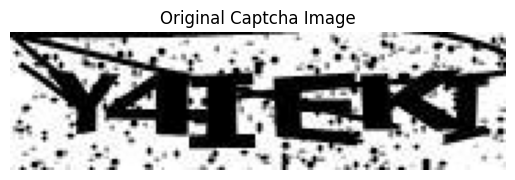

In [331]:
path = 'C:/Users/Pichau/Desktop/Projetos/ICV/captcha/dados/teste/009012.jpg'
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
original_image = read_captcha_image(path)

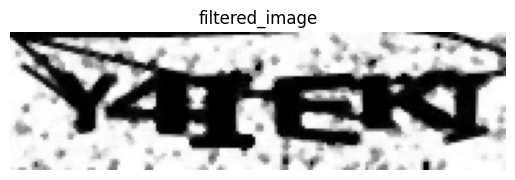

In [332]:
median_filtered = median_filter(original_image)

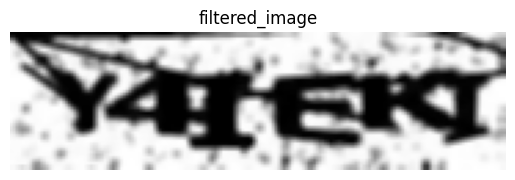

In [333]:
mean_filtered = mean_filter(median_filtered)

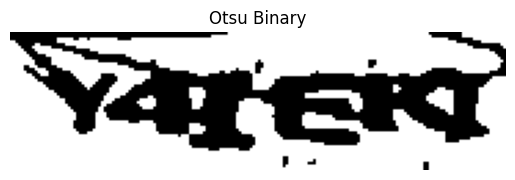

In [334]:
binary_image = otsu_binarization(mean_filtered)

In [335]:
def show(img, title, cmap='gray'):
    plt.figure(figsize=(6, 3))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

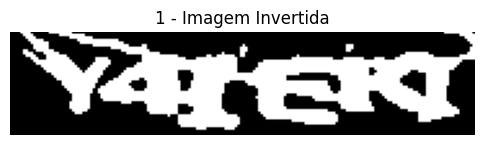

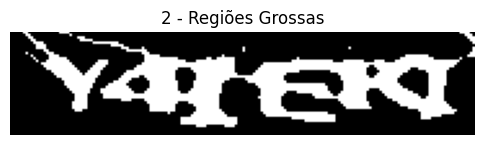

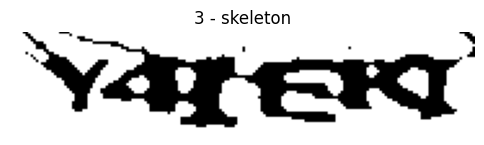

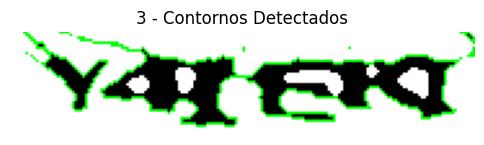


🔍 Regioes detectadas: 2


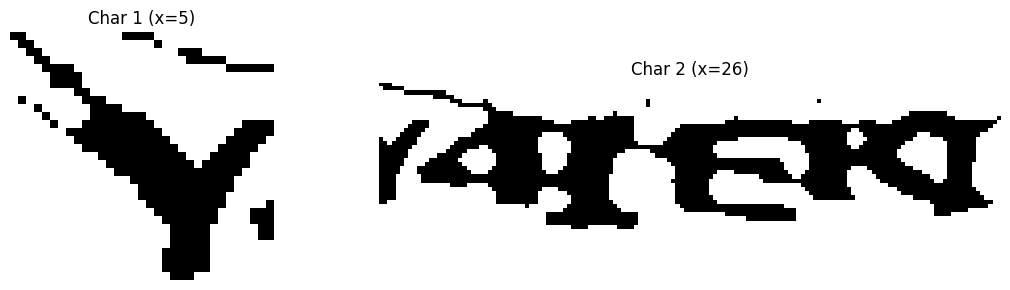

In [336]:
# 1 Pré-processamento
height, width = binary_image.shape
roi = binary_image[int(height*0.1):int(height*0.9), :] # Desconsiderando 10% de cima e de baixo (é possível ignorar essas partes sem perda de informação - pelo menos nas imagens que eu analisei)
inverted = cv2.bitwise_not(roi)
show(inverted, "1 - Imagem Invertida")

# 2 Identificação de regiões grossas
dist_transform = cv2.distanceTransform(inverted, cv2.DIST_L2, 5)
thick_regions = (dist_transform > 1).astype(np.uint8) * 255  # Possivel ajustar 'dist_transform' para melhor adaptação
show(thick_regions, "2 - Regiões Grossas")

skeleton = cv2.bitwise_not(thick_regions)
show(skeleton, "3 - skeleton")

# 3 Extração de caracteres
contours, _ = cv2.findContours(thick_regions, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_img = cv2.cvtColor(skeleton, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 1)
show(contour_img, "3 - Contornos Detectados")

chars = []
min_height, min_width = 10, 3

for i, cnt in enumerate(contours):
    x, y, w, h = cv2.boundingRect(cnt)
    if h >= min_height and w >= min_width:
        char_roi = skeleton[y:y+h, x:x+w]
        chars.append((x, char_roi))

# 4 Regiões de interesse
if chars:
    chars.sort(key=lambda c: c[0])
    print(f"\n🔍 Regioes detectadas: {len(chars)}")
    
    plt.figure(figsize=(12, 3))
    for i, (x, roi) in enumerate(chars):
        plt.subplot(1, len(chars), i+1)
        plt.imshow(roi, cmap='gray')
        plt.title(f"Char {i+1} (x={x})")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Nenhuma regiao detectada")


